# Imports

In [1]:
import importlib
import automaticR0 as f  # Our defined functions
import numpy as np
import matplotlib.pyplot as plt
import matplotlib_inline
import numpy as np
import math
from math import *

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

importlib.reload(f)

GRatio = (1 + 5 ** .5) / 2

WIDTH = .5
DASH = (10, 10)


In [2]:
importlib.reload(f)

print(f.subSet(f.loadModel('test'), 'E0', 'I'))

print(f.getSusceptibleNodes(f.loadModel('test')))

test = f.loadModel('test')
compartments = f.getCompartments(test)
print([compartments.index(x) for x in f.getSusceptibleNodes(test)])

Model verified.
Writing model to file models/test.json.
File name already exists.
Overwriting file.
['E0', 'E1', 'E2', 'E3', 'I']
Model verified.
Writing model to file models/test.json.
File name already exists.
Overwriting file.
['S']
Model verified.
Writing model to file models/test.json.
File name already exists.
Overwriting file.
[0]


# Solving models

{'Rt(S,I)': 2.4998340904203693}


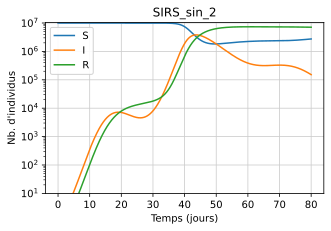

In [3]:
importlib.reload(f)


t_final = {
    'SIRS_vars': 150,
    'SIRS_deaths': 120,
    'SIR_test3': 150,
    'SIS_deaths_2': 150,
    'SIS': 100,
    'SIR_betajump20': 125,
    'SIR': 125,
    'SIR_I_sep': 50,
    'SIR2': 125,
    'SIR3': 200,
    'SIR_vars': 200,
    'hospitalized': 36,
    'SIR_test2': 175,
    'SIR_sin_2': 80,
    'SIRS_sin_2': 80
}


for modelName in ['SIRS_sin_2']:

    model = f.loadModel(modelName, printText=False)
    solution, t_span = f.solve(model, (0, t_final[modelName]), 100)

    labels = f.getCompartments(model)

    if modelName == 'SIR_I_sep':
        def combine(sol):
            newSolution = np.zeros((sol.shape[0], sol.shape[1] - 2))

            newSolution[:, 0] = sol[:, 0]
            newSolution[:, 1] = sol[:, 1] + sol[:, 2] + sol[:, 3]
            newSolution[:, 2] = sol[:, 4]
            newSolution[:, 3] = sol[:, 5]
            newSolution[:, 4] = sol[:, 6]

            return newSolution, sol, ['S', 'I', 'R', 'Null_n', 'Null_m']

        solution, oldSolution, labels = combine(solution)

    nullmPos = labels.index('Null_m')
    nullnPos = labels.index('Null_n')

    solution[:, nullmPos] = - solution[:, nullmPos]
    curvesToPlot = list(range(solution.shape[1]))

    diffNullm = np.max(np.abs(solution[:, nullmPos] - solution[0, nullmPos]))
    diffNulln = np.max(np.abs(solution[:, nullnPos] - solution[0, nullnPos]))
    if diffNullm < 1:
        curvesToPlot.remove(nullmPos)
    if diffNulln < 1:
        curvesToPlot.remove(nullnPos)

    fig = plt.figure(figsize=(5, 5 / GRatio))
    f.plotCurves(t_span,
                 np.transpose(solution),
                 toPlot=curvesToPlot,
                 labels=labels,
                 title=modelName if modelName != 'hospitalized' else '',
                 scales=['linear', 'linear'],
                 xlabel='Temps (jours)'
                 if modelName != 'hospitalized'
                 else 'Temps (mois)',
                 ylabel='Nb. d\'individus')

    # additional curves
    # plt.plot(t_span, f.infCurve(model, solution if
    #                             modelName != 'SIR_I_sep'
    #                             else oldSolution, t_span),
    #          label='$\\nu$', c='#8E4585')
    N = np.array([f.getPopulation(model, x)['Sum']
                  for x in solution])
    diffN = np.max(np.abs(N - N[0]))
    if diffN > 1:
        plt.plot(t_span, N, label='$N$', c='#8E4585')

    # lines
    plt.ylim(bottom=10)
    plt.axhline(y=1, linestyle='--', color='grey',
                linewidth=WIDTH, dashes=DASH)
    plt.yscale('log')

    f.mod(model, printText=False)

    model, modelMod, _, r0 = f.computeR0(
        modelName, (0, 300), printInit=False, printWarnings=False,
        scaledInfs=False, printText=False)

    print(r0)

    plt.legend(loc='best', framealpha=.9)
    plt.grid(axis='both', color='.80')

    if modelName == 'hospitalized':
        hIndex = labels.index('H')
        print(np.max(solution[:, hIndex]))

        xint = range(0, t_final['hospitalized'] + 1, 6)
        plt.xticks(xint)

    fig.savefig(f'graphs/curves_{modelName}.pdf', bbox_inches='tight')
    plt.show()


# $\mathcal{R}_t$ curves

In [4]:
parameters = {
    'SIR_deaths': {
        't_span_rt': (0, 80),
        'R0': 4,
        'legendLoc': 'center left'
    },
    'SIR_vars': {
        't_span_rt': (40, 90),
        'R0': 10,
        'legendLoc': 'center left'
    },
    'SIR_test2': {
        't_span_rt': (0, 220),
        'R0': 4,
        'legendLoc': 'upper right'
    },
    'SIRS_vacc_morts': {
        't_span_rt': (0, 200),
        'R0': 32 / 15,
        'legendLoc': 'center left'
    },
    'SI': {
        't_span_rt': (0, 60),
        'R0': 0,
        'legendLoc': 'best'
    },
    'SIR': {
        't_span_rt': (0, 50),
        'R0': 4,
        'legendLoc': 'upper right'
    },
    'SIR_I_sep': {
        't_span_rt': (0, 50),
        'R0': 4,
        'legendLoc': 'upper right'
    },
    'SIR copy': {
        't_span_rt': (0, 50),
        'R0': 2,
        'legendLoc': 'upper right'
    },
    'SIR2': {
        't_span_rt': (0, 50),
        'R0': 4,
        'legendLoc': 'center left'
    },
    'SIR_betajump20': {
        't_span_rt': (0, 50),
        'R0': 3,
        'legendLoc': 'lower left'
    },
    'SIR_gammajump20': {
        't_span_rt': (0, 50),
        'R0': 3,
        'legendLoc': 'lower left'
    },
    'SIR3': {
        't_span_rt': (0, 200),
        'R0': 3,
        'legendLoc': 'center left'
    },
    'SIRS_deaths': {
        't_span_rt': (0, 260),
        'R0': 4,
        'legendLoc': 'upper right'
    },
    'vacMort': {
        't_span_rt': (0, 260),
        'R0': .4 * .04 / ((.1 + .01 + .04) * (.04 + .01)) * 5 / 4,
        'legendLoc': 'upper right'
    },
    'SIR_sin_2': {
        't_span_rt': (0, 80),
        'R0': 0,
        'legendLoc': 'upper right'
    },
    'SIRS_sin_2': {
        't_span_rt': (0, 100),
        'R0': (.5 + .4 * np.sin(2 * pi * np.arange(0, 100 + .01, .01) / 30 % 30)) / .2,
        'legendLoc': 'upper right'
    }
}



Computation of Rt
Model verified.
Writing model to file models/SIR2.json.
File name already exists.
Overwriting file.

Creating new model!
Writing model to file models/SIR2_mod.json.
File name already exists.
Véfication faite, les deux modèles sont identiques.


100%|██████████| 51/51 [00:03<00:00, 13.58it/s]


Rt computation done

Infected extrema at [26.26]
Rt = 1 at [25.94]
Time difference: [0.32]
Rt at start, ana and sim: 3.99999960000004 3.9766862986000615
Rt at end, ana and sim: 0.08463003054390451 0.08205307137199706


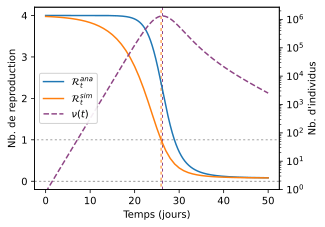


Computation of Rt
Model verified.
Writing model to file models/SIR3.json.
File name already exists.
Overwriting file.

Creating new model!
Writing model to file models/SIR3_mod.json.
File name already exists.
Véfication faite, les deux modèles sont identiques.


100%|██████████| 201/201 [00:06<00:00, 31.43it/s]


Rt computation done

Infected extrema at [116.96]
Rt = 1 at [116.1]
Time difference: [0.86]
Rt at start, ana and sim: 2.9999997000000302 2.9958418490837255
Rt at end, ana and sim: 0.18631150650977693 0.1825668005407003


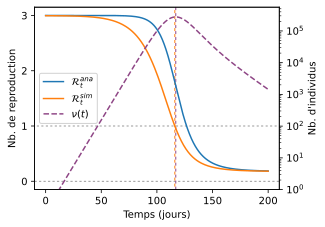


Computation of Rt
Model verified.
Writing model to file models/SIR_test2.json.
File name already exists.
Overwriting file.

Creating new model!
Writing model to file models/SIR_test2_mod.json.
File name already exists.
Véfication faite, les deux modèles sont identiques.


100%|██████████| 221/221 [00:12<00:00, 17.14it/s]


Rt computation done

Infected extrema at [126.46]
Rt = 1 at [126.0]
Time difference: [0.46]
Rt at start, ana and sim: 3.99999960000004 3.9987586413488536
Rt at end, ana and sim: 0.6759984255509937 0.35151807185946526


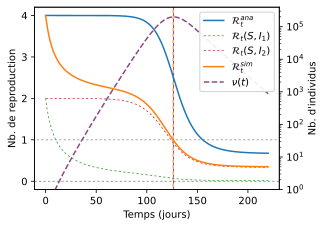


Computation of Rt
Model verified.
Writing model to file models/SIRS_deaths.json.
File name already exists.
Overwriting file.

Creating new model!
Writing model to file models/SIRS_deaths_mod.json.
File name already exists.
Véfication faite, les deux modèles sont identiques.


100%|██████████| 261/261 [00:13<00:00, 19.49it/s]


Rt computation done

Infected extrema at [62.22, 116.42, 182.33, 247.16]
Rt = 1 at [62.18, 121.56, 184.58, 251.3]
Time difference: [0.04, 5.14, 2.25, 4.14]
Rt at start, ana and sim: 3.9999999600000002 3.9171623258960295
Rt at end, ana and sim: 1.0115216607452273 1.007701658064423


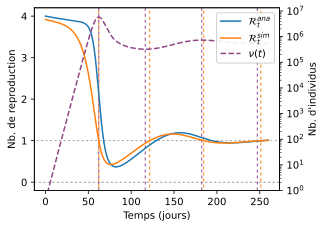


Computation of Rt
Model verified.
Writing model to file models/vacMort.json.
File name already exists.
Overwriting file.

Creating new model!
Writing model to file models/vacMort_mod.json.
File name already exists.
Véfication faite, les deux modèles sont identiques.


100%|██████████| 261/261 [00:12<00:00, 20.99it/s]


Rt computation done

Infected extrema at [54.98, 118.92, 169.51, 205.51, 243.17]
Rt = 1 at [54.24, 120.77, 171.83, 209.5, 247.17]
Time difference: [0.74, 1.85, 2.32, 3.99, 4.0]
Rt at start, ana and sim: 2.6666664000000266 2.648190773042237
Rt at end, ana and sim: 0.9987266967749877 0.9988199242633413


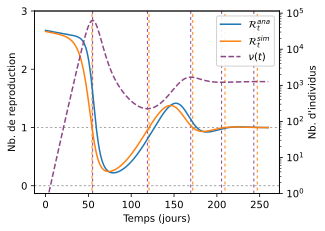


Computation of Rt
Model verified.
Writing model to file models/SIRS_sin_2.json.
File name already exists.
Overwriting file.

Creating new model!
Writing model to file models/SIRS_sin_2_mod.json.
File name already exists.
Véfication faite, les deux modèles sont identiques.


100%|██████████| 101/101 [00:05<00:00, 18.23it/s]


Rt computation done

Infected extrema at [16.18, 23.07, 41.03, 53.45, 68.19, 83.39]
Rt = 1 at [19.05, 25.95, 41.3, 64.82, 70.33, 90.5]
Time difference: [2.87, 2.88, 0.27, 11.37, 2.14, 7.11]
Rt at start, ana and sim: 2.499999750000025 2.499834088651689
Rt at end, ana and sim: 1.627927944057446 1.6136633992339


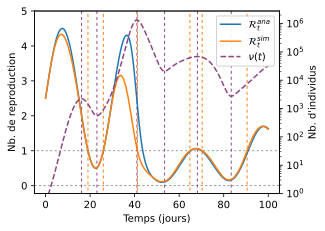

In [5]:
importlib.reload(f)

for name in ['SIR2', 'SIR3', 'SIR_test2', 'SIRS_deaths', 'vacMort', 'SIRS_sin_2']:
# for name in ['SIRS_sin_2']:
    rtCurves = \
        f.compare(name, **parameters[name], sub_rt=1,
                  plotANA=True,
                  plotInfected=True,
                  title='',
                  useLog=True,
                  printText=True,
                  forceColors=True,
                  scale=11/16)
    plt.show()


100%|██████████| 51/51 [00:02<00:00, 17.44it/s]


Rt at start, ana and sim: 3.99999960000004 3.9766862986000615
Rt at end, ana and sim: 0.08463003054390451 0.08205307137199706


100%|██████████| 51/51 [00:02<00:00, 17.61it/s]


Rt at start, ana and sim: 2.9999997000000302 3.9766862986000615
Rt at end, ana and sim: 0.10379365912418154 0.13987973563060085


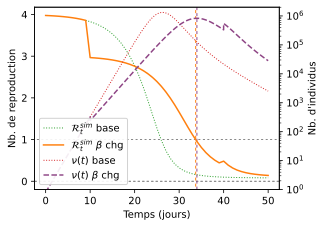

100%|██████████| 51/51 [00:02<00:00, 17.31it/s]


Rt at start, ana and sim: 3.99999960000004 3.9766862986000615
Rt at end, ana and sim: 0.08463003054390451 0.08205307137199706


100%|██████████| 51/51 [00:03<00:00, 16.89it/s]


Rt at start, ana and sim: 2.9999997000000302 3.9766862986000615
Rt at end, ana and sim: 0.16367184414160013 0.2541376976920653


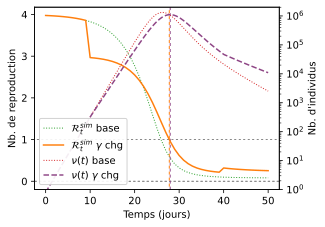

100%|██████████| 51/51 [00:02<00:00, 17.18it/s]


Rt at start, ana and sim: 3.99999960000004 3.9766862986000615
Rt at end, ana and sim: 0.08463003054390451 0.08205307137199706


100%|██████████| 51/51 [00:09<00:00,  5.29it/s]


Rt at start, ana and sim: 3.99999960000004 3.9992422116632107
Rt at end, ana and sim: 0.07932660243943918 0.0793162891383539


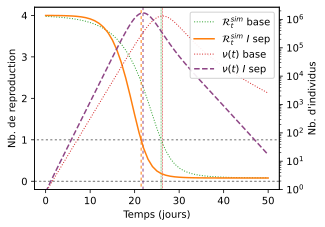

In [6]:
importlib.reload(f)

fig, ax1 = plt.subplots(figsize=(4*1.1, 3*1.1))
ax2 = ax1.twinx()

rtCurves = \
    f.compare('SIR', **parameters['SIR'], sub_rt=1,
              plotANA=False,
              plotInfected=True,
              title='',
              useLog=True,
              printText=False,
              whereToPlot=(fig, ax1, ax2),
              plotStyle=':',
              forceColors=False,
              drawVertical=False,
              saveGraph=False,
              plotFrom=10,
              addToLegends=' base',
              colors=['C2', 'C3'])
rtCurves = \
    f.compare('SIR_betajump20', **parameters['SIR_betajump20'], sub_rt=1,
              plotANA=False,
              plotInfected=True,
              title='',
              useLog=True,
              printText=False,
              whereToPlot=(fig, ax1, ax2),
              forceColors=True,
              saveGraph=True,
              graphName='betaJump',
              printR0=False,
              addToLegends=' $\\beta$ chg')
plt.show()

importlib.reload(f)

fig, ax1 = plt.subplots(figsize=(4*1.1, 3*1.1))
ax2 = ax1.twinx()

rtCurves = \
    f.compare('SIR', **parameters['SIR'], sub_rt=1,
              plotANA=False,
              plotInfected=True,
              title='',
              useLog=True,
              printText=False,
              whereToPlot=(fig, ax1, ax2),
              plotStyle=':',
              forceColors=False,
              drawVertical=False,
              saveGraph=False,
              plotFrom=10,
              addToLegends=' base',
              colors=['C2', 'C3'])
rtCurves = \
    f.compare('SIR_gammajump20', **parameters['SIR_gammajump20'], sub_rt=1,
              plotANA=False,
              plotInfected=True,
              title='',
              useLog=True,
              printText=False,
              whereToPlot=(fig, ax1, ax2),
              forceColors=True,
              saveGraph=True,
              graphName='gammaJump',
              printR0=False,
              addToLegends=' $\\gamma$ chg')
plt.show()

importlib.reload(f)

fig, ax1 = plt.subplots(figsize=(4*1.1, 3*1.1))
ax2 = ax1.twinx()

rtCurves = \
    f.compare('SIR', **parameters['SIR'], sub_rt=1,
              plotANA=False,
              plotInfected=True,
              title='',
              useLog=True,
              printText=False,
              whereToPlot=(fig, ax1, ax2),
              plotStyle=':',
              forceColors=False,
              drawVertical=True,
              saveGraph=False,
              addToLegends=' base',
              colors=['C2', 'C3'])
rtCurves = \
    f.compare('SIR_I_sep', **parameters['SIR_I_sep'], sub_rt=1,
              plotANA=False,
              plotInfected=True,
              title='',
              useLog=True,
              printText=False,
              whereToPlot=(fig, ax1, ax2),
              forceColors=True,
              saveGraph=True,
              graphName='infectedSep',
              printR0=False,
              addToLegends=' $I$ sep')
plt.show()


In [7]:
SIR_I_sep = f.loadModel('SIR_I_sep', printText=False)
# f.printModel(SIR_I_sep)

del SIR_I_sep['compartments']['I2']
del SIR_I_sep['compartments']['I3']
SIR_I_sep['flows']['migrations'] = []
SIR_I_sep['flows']['infections'][0]['contact'] = 'I1'

r0sTab = []

for i in range(1, 10+1):
    SIR_I_sep['name'] = f'SIR_zzz_{i}'

    if i > 1:
        SIR_I_sep['compartments'][f'I{i}'] = 0
        SIR_I_sep['flows']['infections'][0]['contact'] += f'+I{i}'

        migrationToI = {
            'from': f'I{i-1}',
            'to': f'I{i}',
            'rate': f'I{i-1}',
            'contact': 'Null_m',
            'parameter': f'{i * .2}'
        }
        SIR_I_sep['flows']['migrations'].append(migrationToI)

    for flow in SIR_I_sep['flows']['migrations']:
        flow['parameter'] = f'{i * .2}'

    SIR_I_sep['flows']['recoveries'][0]['from'] = f'I{i}'
    SIR_I_sep['flows']['recoveries'][0]['rate'] = f'I{i}'
    SIR_I_sep['flows']['recoveries'][0]['parameter'] = f'{i * .2}'

    f.writeModel(SIR_I_sep, printText=False)

    _, _, _, r0 = f.computeR0(f'SIR_zzz_{i}', printText=False)

    r0sTab.append(4 - r0['Rt(S,I1)'])


In [8]:
for x in r0sTab:
    print(x)


0.02331370139993849
0.0036179245419045714
0.0007577883367910765
0.0002152474994825404
8.414751552443533e-05
4.3939547006210944e-05
2.8460100216509687e-05
2.1200749086514037e-05
1.722321911623581e-05
1.477714144559883e-05


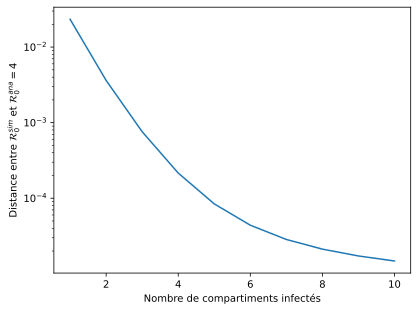

In [9]:
fig = plt.figure()

plt.plot(list(range(1, 10+1)), r0sTab)
plt.yscale('log')
plt.xlabel('Nombre de compartiments infectés')
plt.ylabel(
    'Distance entre $\\mathcal{R}_0^{sim}$ et $\\mathcal{R}_0^{ana} = 4$')

fig.savefig('graphs/I_sep_R0.pdf', bbox_inches='tight')


In [10]:
import automaticR0 as f
import importlib
import os
importlib.reload(f)

allModels = [x.split('.json')[0] for x in os.listdir(
    'models') if not x.endswith('_mod.json')]

for name in allModels:
    print(name)

    measures = {
        'layerDistance': 1,
        'nodeDistance': 2,
        'varDistance': .25,
        'nullDistance': .8,
        'baseAngle': 10,
        'contactPositions': ("2/5", "3/5"),
        'scale': 1
    }

    # f.printModel(f.loadModel(name, True, False))

    f.createLaTeX(f.loadModel(name, True, False), **measures)

    f.createLaTeX(f.mod(f.loadModel(name, True, False),
                        overWrite=True), **measures)


hospitalized
Tikz created for hospitalized
Tikz created for hospitalized_mod
seirs
Tikz created for seirs
Tikz created for seirs_mod
SI
Tikz created for SI
Tikz created for SI_mod
SIR copy
Tikz created for SIR copy
Tikz created for SIR copy_mod
SIR
Tikz created for SIR
Tikz created for SIR_mod
SIR2
Tikz created for SIR2
Tikz created for SIR2_mod
SIR3
Tikz created for SIR3
Tikz created for SIR3_mod
SIRS
Tikz created for SIRS
Tikz created for SIRS_mod
SIRS_deaths
Tikz created for SIRS_deaths
Tikz created for SIRS_deaths_mod
SIRS_sin_2
Tikz created for SIRS_sin_2
Tikz created for SIRS_sin_2_mod
SIRS_vacc_morts
Tikz created for SIRS_vacc_morts
Tikz created for SIRS_vacc_morts_mod
SIRS_vars
Tikz created for SIRS_vars
Tikz created for SIRS_vars_mod
SIR_betajump20
Tikz created for SIR_betajump20
Tikz created for SIR_betajump20_mod
SIR_deaths
Tikz created for SIR_deaths
Tikz created for SIR_deaths_mod
SIR_gammajump20
Tikz created for SIR_gammajump20
Tikz created for SIR_gammajump20_mod
SIR_I_s

In [11]:
f.verifyModel(f.loadModel('test'), 'test', True)

Model verified.
Writing model to file models/test.json.
File name already exists.
Overwriting file.
Model verified.


{'name': 'test',
 'compartments': {'S': 100000000.0,
  'E0': 0,
  'E1': 0,
  'E2': 0,
  'E3': 0,
  'I': 3,
  'Null_n': 0,
  'Null_m': 0},
 'flows': {'infections': [{'from': 'S',
    'to': 'E0',
    'rate': 'S',
    'contact': 'I',
    'parameter': '0'}],
  'transfers': [{'from': 'E0',
    'to': 'E1',
    'rate': 'E0',
    'contact': 'Null_m',
    'parameter': '0'},
   {'from': 'E1',
    'to': 'E2',
    'rate': 'E1',
    'contact': 'Null_m',
    'parameter': '0'},
   {'from': 'E2',
    'to': 'E3',
    'rate': 'E2',
    'contact': 'Null_m',
    'parameter': '0'},
   {'from': 'E3',
    'to': 'E1',
    'rate': 'E3',
    'contact': 'Null_m',
    'parameter': '0'},
   {'from': 'E2',
    'to': 'I',
    'rate': 'E2',
    'contact': 'Null_m',
    'parameter': '0'}],
  'recoveries': [{'from': 'I',
    'to': 'R',
    'rate': 'I',
    'contact': 'Null_m',
    'parameter': '0'}]}}